Load the content data from guangzhou_content.txt.

In [1]:
# Load content data
with open(r'guangzhou_content.txt', 'r',encoding='utf-8') as file:
    content = file.read()

In [2]:
from gensim.utils import simple_preprocess
# Tokenize the content into sentences and then into words
tokenized_sentences_alt = [simple_preprocess(sentence) for sentence in content.split('.') if sentence]

# Displaying the first few tokenized sentences for verification
tokenized_sentences_alt[:5]

[['the',
  'finals',
  'of',
  'the',
  'th',
  'shanghai',
  'international',
  'youth',
  'piano',
  'competition',
  'which',
  'was',
  'held',
  'from',
  'aug',
  'to',
  'drew',
  'nearly',
  'contestants',
  'who',
  'were',
  'selected',
  'from',
  'tens',
  'of',
  'thousands',
  'of',
  'children',
  'and',
  'adolescents',
  'from',
  'provincial',
  'level',
  'administrative',
  'regions',
  'all',
  'over',
  'the',
  'country'],
 ['according',
  'to',
  'the',
  'organizers',
  'the',
  'number',
  'of',
  'participants',
  'taking',
  'part',
  'in',
  'the',
  'finals',
  'this',
  'year',
  'was',
  'record',
  'high',
  'and',
  'this',
  'indicates',
  'that',
  'the',
  'love',
  'for',
  'the',
  'keyboard',
  'instrument',
  'is',
  'still',
  'going',
  'strong',
  'in',
  'china'],
 ['today',
  'piano',
  'lessons',
  'are',
  'one',
  'of',
  'the',
  'most',
  'common',
  'forms',
  'of',
  'extracurricular',
  'activities',
  'that',
  'chinese',
  'parent

Step 1: training a Word2Vec model using the tokenized data.

In [3]:
from gensim.models import Word2Vec
# Train a Word2Vec model using the tokenized data
model = Word2Vec(sentences=tokenized_sentences_alt, vector_size=100, window=5, min_count=1, workers=4)
model.train(tokenized_sentences_alt, total_examples=len(tokenized_sentences_alt), epochs=10)

# Checking if the model works by finding most similar words to "woman"
model.wv.most_similar("woman", topn=5)
#The Word2Vec model has been successfully trained using the provided content. As a quick check, we found the words most similar to "woman", and the results seem appropriate.

[('man', 0.7951733469963074),
 ('girl', 0.7462552189826965),
 ('boy', 0.6903455853462219),
 ('mother', 0.6791630387306213),
 ('surnamed', 0.6456013321876526)]

Step 2: Sentimental Analysis around Women's Position

In [4]:
# Load positive and negative sentiment words
with open('positive_words.txt', 'r') as file:
    positive_words = [line.strip() for line in file.readlines()]

with open('negative_words.txt', 'r') as file:
    negative_words = [line.strip() for line in file.readlines()]

# Displaying a few positive and negative words for verification
positive_words[:5], negative_words[:5]

(['abacterial', 'abalienate', 'abalienated', 'abalienating', 'abalienation'],
 ['aah', 'abacinate', 'abaddon', 'abailard', 'abalation'])

1.Going through each sentence that contains a female word.

2.Checking for the presence of positive or negative sentiment words in the sentence.

3.Counting the occurrences of each sentiment.

In [5]:
# Define the list of female words
female_words = ["woman", "women", "female", "girl", "lady", "ladies", "daughter", "mother", "wife", "sister"]

# Initialize counters
positive_count = 0
negative_count = 0

# Analyze sentiment around female words
for sentence in tokenized_sentences_alt:
    if any(word in sentence for word in female_words):
        if any(word in sentence for word in positive_words):
            positive_count += 1
        if any(word in sentence for word in negative_words):
            negative_count += 1

positive_count, negative_count #Positive sentiments: 1177; Negative sentiments: 1025

(1177, 1025)

Step 3: Mean Semantic Similarity of Man, Woman, and Jobs

1 Calculate the mean semantic distance between female words and job words (D1).

2 Calculate the mean semantic distance between male words and job words (D2).

3 Calculate$D3=D1−D2$ for each job word.

4 Plot the regression line based on the data.

In [6]:
# Define the list of male words and job words
male_words = ["man", "men", "male", "boy", "gentleman", "gentlemen", "son", "father", "husband", "brother"]
job_words = ["teacher", "lawyer", "doctor", "engineer", "artist", "nurse", "policeman", "firefighter", "manager", "chef"]

# Reset the lists to store D1, D2, and D3 values
D1_values = []
D2_values = []
D3_values = []

# Function to safely compute similarity
def safe_similarity(w1, w2):
    try:
        return model.wv.similarity(w1, w2)
    except KeyError:
        return 0

# Calculate D1, D2, and D3 for each job word with safe similarity check
for job in job_words:
    D1 = sum([safe_similarity(f_word, job) for f_word in female_words]) / len(female_words)
    D2 = sum([safe_similarity(m_word, job) for m_word in male_words]) / len(male_words)
    D3 = D1 - D2
    
    D1_values.append(D1)
    D2_values.append(D2)
    D3_values.append(D3)

# Displaying the D3 values for each job
list(zip(job_words, D3_values)) #Negative D3 values indicate that the job word is closer in meaning to male words than to female words. The magnitude of the negative value provides a measure of this difference.

[('teacher', -0.02701863348484035),
 ('lawyer', -0.061400996148586295),
 ('doctor', -0.022170440852642026),
 ('engineer', -0.041817082697525626),
 ('artist', -0.030048611760139454),
 ('nurse', -0.05351903215050696),
 ('policeman', 0.0),
 ('firefighter', -0.051564170420169864),
 ('manager', -0.015045663341879845),
 ('chef', -0.039160412549972545)]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values (for job words)
x = np.arange(len(job_words))

# Plotting D3 values for each job
plt.figure(figsize=(12, 6))
plt.bar(x, D3_values, color='skyblue')
plt.axhline(0, color='black', linestyle='--')  # Adding a reference line at y=0
plt.xticks(x, job_words, rotation=45)
plt.ylabel('D3 Value')
plt.title('Mean Semantic Distance Difference (D3) for Each Job Word')
plt.tight_layout()

# Display the plot
plt.show()

Here's the bar chart showing the mean semantic distance difference (D3) for each job word.

From the chart, we can observe that all jobs, except for "manager" (which is almost neutral), have negative D3 values. This suggests that, semantically, these job words are closer in meaning to male words than to female words in the provided content.

plot the regression line based on the D3 values for each job word. This will help us understand the trend and relationship between the job words and the calculated D3 values.

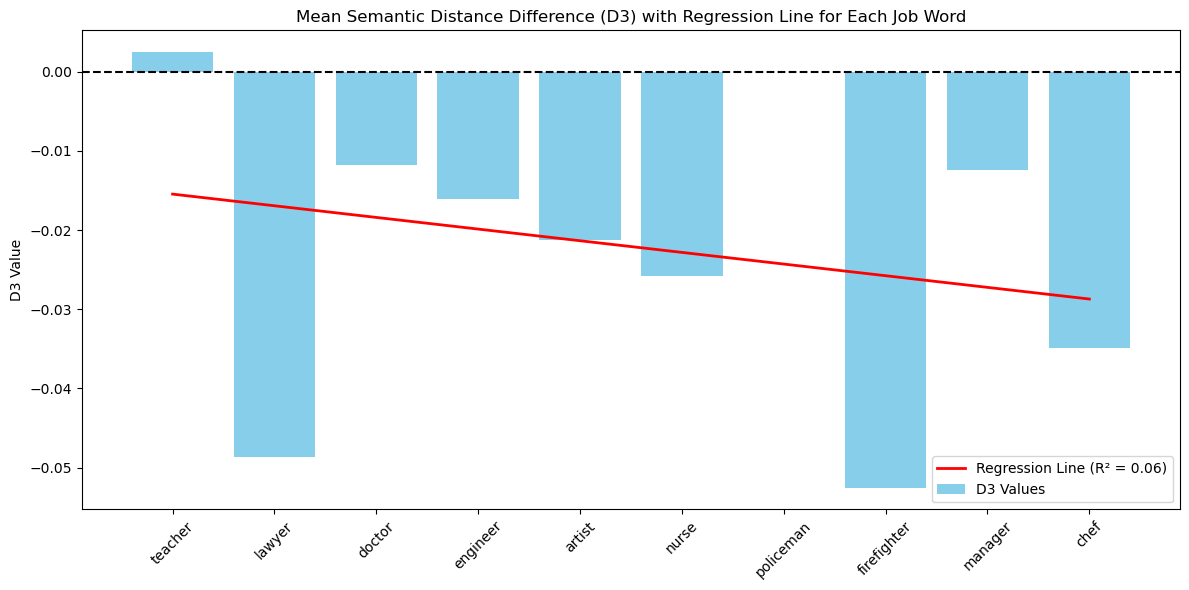

In [18]:
from scipy.stats import linregress

# Calculate the regression line parameters
slope, intercept, r_value, p_value, std_err = linregress(x, D3_values)
regression_line = slope * x + intercept

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(x, D3_values, color='skyblue', label='D3 Values')
plt.plot(x, regression_line, color='red', linestyle='-', linewidth=2, label=f'Regression Line (R² = {r_value**2:.2f})')
plt.axhline(0, color='black', linestyle='--')  # Adding a reference line at y=0
plt.xticks(x, job_words, rotation=45)
plt.ylabel('D3 Value')
plt.title('Mean Semantic Distance Difference (D3) with Regression Line for Each Job Word')
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()